In [11]:
#| echo: false
import pandas as pd  
import numpy as np  
from scipy.stats import pearsonr, pointbiserialr, chi2_contingency  
import matplotlib.pyplot as plt  
from matplotlib.font_manager import FontProperties  

# Read the data  
file_path = 'data/listings.csv'    #which is the path in this repository  
airbnb_data = pd.read_csv(file_path)  

In [12]:
# Calculate the estimation of nights booked for each listing
airbnb_data = airbnb_data[airbnb_data['availability_365'] > 0] 
airbnb_data['estimated_nights_booked'] = airbnb_data['reviews_per_month'] * 12 * airbnb_data['minimum_nights'] * 2 

In [13]:
#Data cleaning: assign the estimated nights booked to each borough
# Replace NaN with 0
airbnb_data['estimated_nights_booked'] = airbnb_data['estimated_nights_booked'].fillna(0)

# Convert the column to integers
airbnb_data['estimated_nights_booked'] = airbnb_data['estimated_nights_booked'].astype(int)

#Count the number of listings in each borough using 'neighbourhood' column
borough_counts = airbnb_data['neighbourhood'].value_counts()
print(borough_counts)

# Filter the DataFrame to include only rows where estimated_nights_booked is greater than 90
filtered_data = airbnb_data[airbnb_data['estimated_nights_booked'] > 90]

#Count the number of listings with estimation of nights booked larger than 90 days in each borough
borough_counts_90 = filtered_data['neighbourhood'].value_counts()
print(borough_counts_90)

neighbourhood
Westminster               7141
Kensington and Chelsea    4324
Tower Hamlets             4191
Camden                    3831
Hackney                   3241
Southwark                 2917
Wandsworth                2803
Lambeth                   2779
Islington                 2576
Hammersmith and Fulham    2526
Brent                     1913
Barnet                    1628
Lewisham                  1625
Newham                    1572
Ealing                    1502
Haringey                  1457
Greenwich                 1402
Waltham Forest            1167
Croydon                   1167
Merton                     933
Hounslow                   879
Richmond upon Thames       832
Hillingdon                 673
Redbridge                  650
Enfield                    636
Bromley                    576
Barking and Dagenham       485
Kingston upon Thames       480
Bexley                     441
City of London             421
Harrow                     392
Havering                 

In [14]:
# Merge the two series into a DataFrame
combined_data = pd.concat([borough_counts, borough_counts_90], axis=1, keys=['Total_listings', 'More_than_90'])

# Calculate the ratio of listings with more than 90 booked nights per total listings
combined_data['Ratio_of_more_than_90'] = combined_data['More_than_90'] / combined_data['Total_listings']

# Fill any NaN values that might occur if there are boroughs with no listings > 90 nights
combined_data['Ratio_of_more_than_90'] = combined_data['Ratio_of_more_than_90'].fillna(0)

# Data formatting and round to four decimal places
combined_data['Ratio_of_more_than_90'] = combined_data['Ratio_of_more_than_90'].apply(lambda x: round(x, 4))

# Rename the index label to 'Borough_name'
combined_data.index.rename('Borough_name', inplace=True)

# Output the combined DataFrame
print(combined_data)

                        Total_listings  More_than_90  Ratio_of_more_than_90
Borough_name                                                               
Westminster                       7141          1680                 0.2353
Kensington and Chelsea            4324           904                 0.2091
Tower Hamlets                     4191          1037                 0.2474
Camden                            3831           919                 0.2399
Hackney                           3241           705                 0.2175
Southwark                         2917           720                 0.2468
Wandsworth                        2803           522                 0.1862
Lambeth                           2779           643                 0.2314
Islington                         2576           596                 0.2314
Hammersmith and Fulham            2526           540                 0.2138
Brent                             1913           373                 0.1950
Barnet      

In [15]:
# Load the borough codes
borough_code_file_path = 'data/borough_name_code.csv'
borough_codes = pd.read_csv(borough_code_file_path)

# Reset index in combined_data to turn the index into a regular column
combined_data.reset_index(inplace=True)
borough_codes.reset_index(inplace=True)

#Combine the ratio data and borough name with borough code by borough name
combined_data = pd.merge(combined_data, borough_codes[['Borough_name', 'Borough_code']], on='Borough_name', how='left')

# Set 'Borough_name' back as the index
combined_data.set_index('Borough_name', inplace=True)

# Save the updated DataFrame
combined_data.to_csv('data/borough_listings_ratio.csv', index=True)

In [23]:
import geopandas as gpd
import pandas as pd
import libpysal
from esda.moran import Moran, Moran_Local
import matplotlib.pyplot as plt
import numpy as np
from libpysal.weights import Queen, KNN
import seaborn as sns

# Load data
ratio = pd.read_csv("data/borough_listings_ratio.csv")
borough = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")

In [18]:
borough_ratio = borough.merge(ratio, left_on="GSS_CODE", right_on="Borough_code")

In [19]:
# Calculate neighbors using Queen contiguity
weights = Queen.from_dataframe(borough_ratio)
weights.transform = 'r'  # Row-standardize the weights

/tmp/ipykernel_139/3647185021.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = Queen.from_dataframe(borough_ratio)


Global Moran's I: 0.458
P-value: 0.001


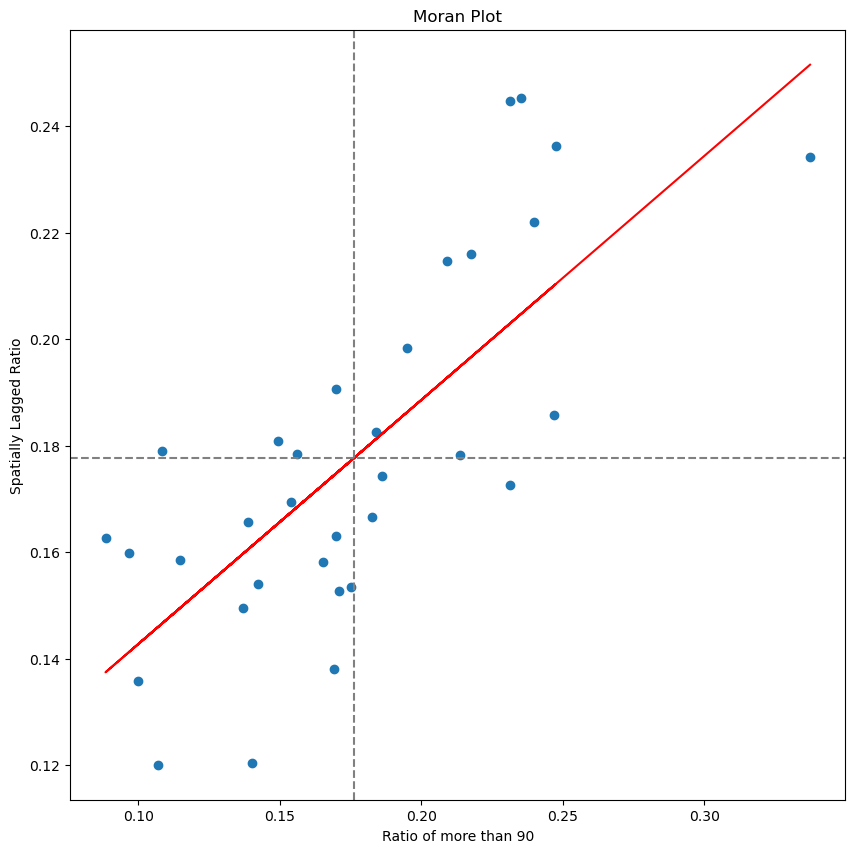

In [20]:
# Global Moran's I
y = borough_ratio['Ratio_of_more_than_90']
moran = Moran(y, weights)
print(f"Global Moran's I: {moran.I:.3f}")
print(f"P-value: {moran.p_sim:.3f}")

# Moran Plot
def moran_plot(y, weights):
    lag = weights.sparse.dot(y)
    slope, intercept = np.polyfit(y, lag, 1)
    
    plt.figure(figsize=(10, 10))
    plt.scatter(y, lag)
    plt.plot(y, slope * y + intercept, 'r')
    plt.xlabel('Ratio of more than 90')
    plt.ylabel('Spatially Lagged Ratio')
    plt.title("Moran Plot")
    plt.axvline(y.mean(), color='gray', linestyle='--')
    plt.axhline(lag.mean(), color='gray', linestyle='--')
    plt.show()

moran_plot(y, weights)

# Local Moran's I
local_moran = Moran_Local(y, weights)
borough_ratio['Ii'] = local_moran.Is
borough_ratio['p_value'] = local_moran.p_sim

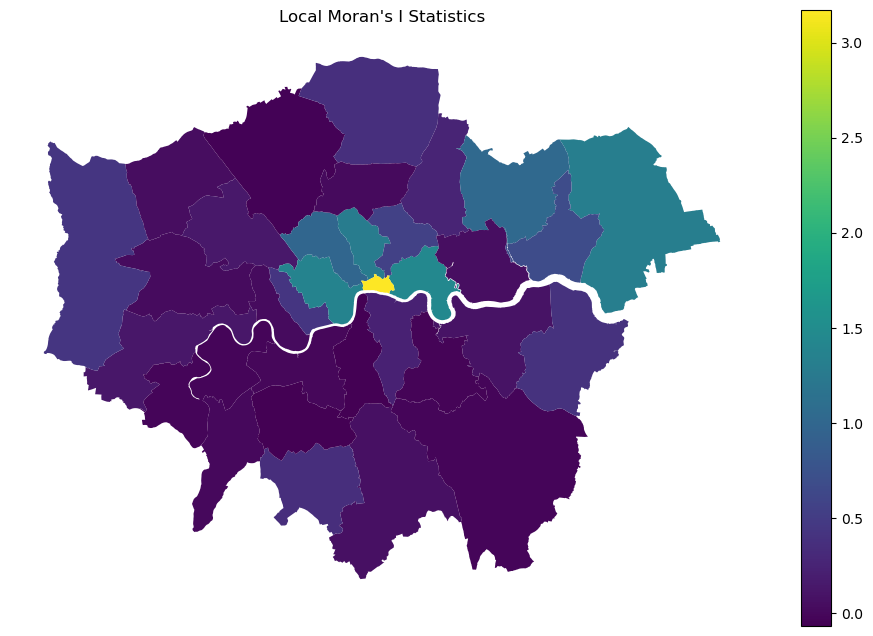

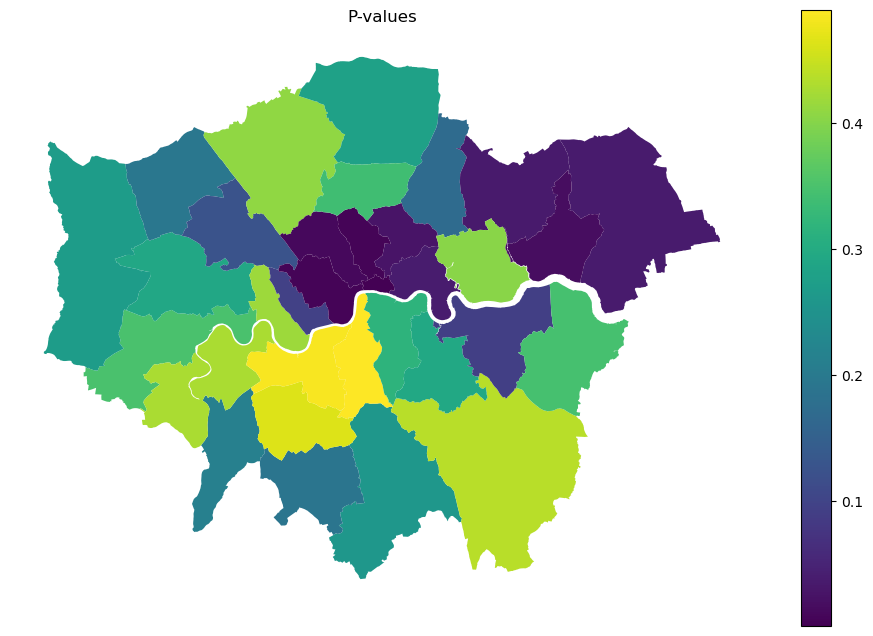

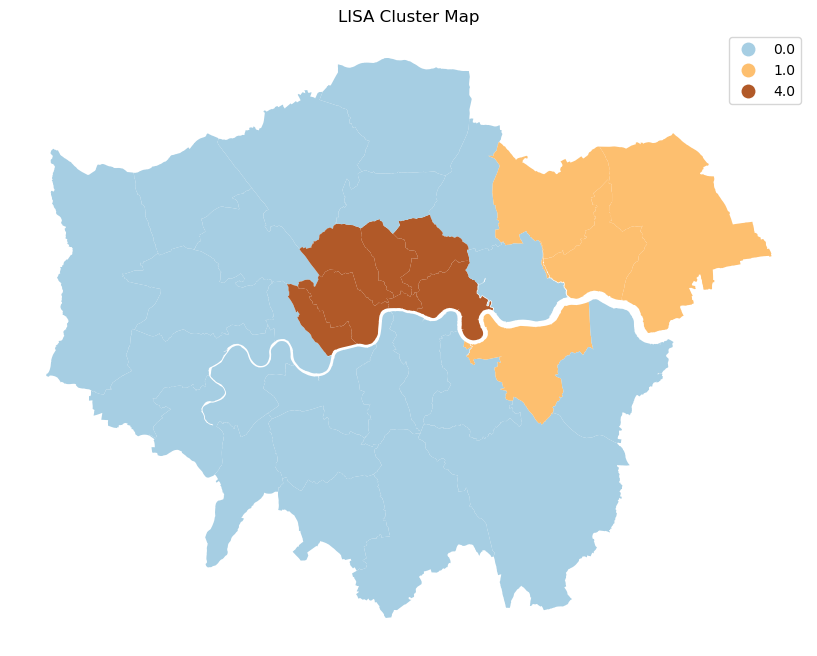

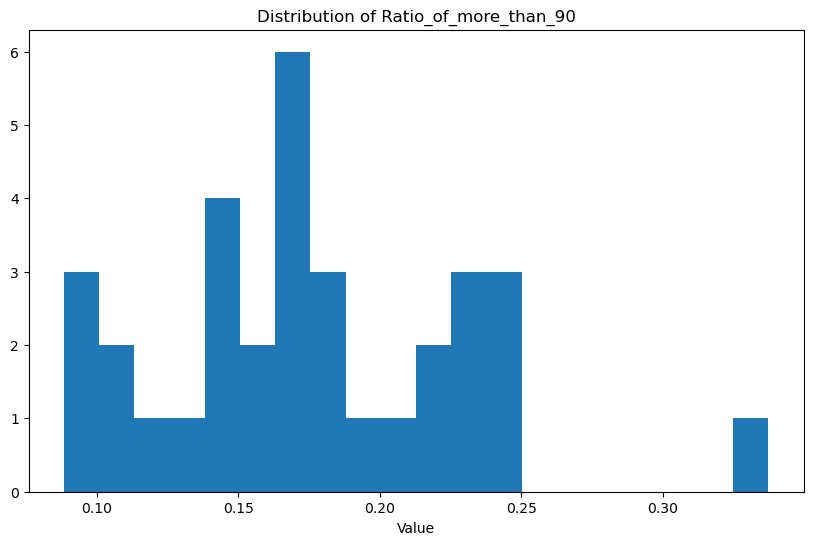

count    33.000000
mean      0.176067
std       0.054405
min       0.088400
25%       0.140200
50%       0.169800
75%       0.213800
max       0.337300
Name: Ratio_of_more_than_90, dtype: float64
count    33.000000
mean      0.444497
std       0.677907
min      -0.066242
25%       0.017070
50%       0.142216
75%       0.559219
max       3.172065
dtype: float64
Number of significant clusters: 11


In [21]:
# Plot Local Moran's I
fig, ax = plt.subplots(figsize=(12, 8))
borough_ratio.plot(column='Ii', legend=True, ax=ax)
plt.title("Local Moran's I Statistics")
plt.axis('off')
plt.show()

# Plot p-values
fig, ax = plt.subplots(figsize=(12, 8))
borough_ratio.plot(column='p_value', legend=True, ax=ax)
plt.title("P-values")
plt.axis('off')
plt.show()

# LISA Cluster Map
sig = 0.1
labels = ['Not Significant', 'Low-Low', 'Low-High', 'High-Low', 'High-High']
colors = ['white', 'blue', 'lightblue', 'pink', 'red']

# Standardize the variable of interest
y_std = (y - y.mean()) / y.std()
lag_std = weights.sparse.dot(y_std)

# Create significance masks
sig_mask = local_moran.p_sim < sig

# Create cluster categories
borough_ratio['quadrant'] = np.zeros(len(y))
borough_ratio.loc[sig_mask, 'quadrant'] = np.where(y_std < 0,
    np.where(lag_std < 0, 1, 2),
    np.where(lag_std < 0, 3, 4))[sig_mask]

# Plot LISA clusters
fig, ax = plt.subplots(figsize=(12, 8))
borough_ratio.plot(column='quadrant', categorical=True, k=5, cmap='Paired',
                  legend=True, ax=ax)
plt.title('LISA Cluster Map')
plt.axis('off')
plt.show()

# Additional analysis plots
plt.figure(figsize=(10, 6))
plt.hist(y, bins=20)
plt.title('Distribution of Ratio_of_more_than_90')
plt.xlabel('Value')
plt.show()

print(y.describe())
# print(local_moran.Is.describe())
print(pd.Series(local_moran.Is).describe())

print(f"Number of significant clusters: {(local_moran.p_sim < 0.1).sum()}")

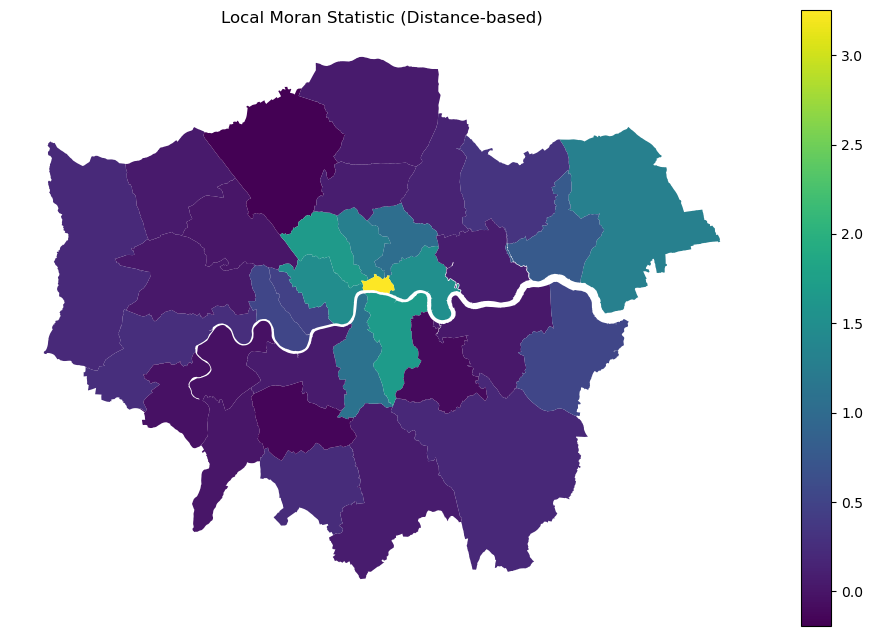

In [22]:
# Distance-based weights (20km)
centroids = borough_ratio.geometry.centroid
coords = np.column_stack((centroids.x, centroids.y))
knn = KNN.from_dataframe(borough_ratio, k=4)  # Approximate 20km neighbors
knn.transform = 'r'

# Calculate Local Moran's I with distance weights
local_moran_dist = Moran_Local(y, knn)

# Add results to GeoDataFrame
borough_ratio['Ii_dist'] = local_moran_dist.Is

# Plot results with distance-based weights
fig, ax = plt.subplots(figsize=(12, 8))
borough_ratio.plot(column='Ii_dist', legend=True, ax=ax)
plt.title("Local Moran Statistic (Distance-based)")
plt.axis('off')
plt.show()